
# Measurement Report
Benthe Smit (s2619806). Other teammates: Tamara Jordens (s2190745), Nienke Vreman (s2333937).


In [13]:
import nglview
import os
import shutil
from scripts import viewer

from Bio.PDB import PDBList, MMCIFParser, Select, PDBIO
import Bio.Align
import os

from pathlib import Path
from warnings import filterwarnings
import time

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem import MACCSkeys
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect

from scripts import viewer
from scripts import bio_align

import pandas as pd
import numpy as np
import glob
import sys
from sklearn import svm, metrics, clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import auc, accuracy_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt


filterwarnings("ignore")
# Fix seed for reproducible results
SEED = 22
#seed_everything(SEED)

#from pymol import cmd
import py3Dmol

from vina import Vina

#from meeko import MoleculePreparation
#from meeko import obutils

import MDAnalysis as mda
from MDAnalysis.coordinates import PDB

#import prolif
#from prolif.plotting.network import LigNetwork

import sys, os, shutil
sys.path.insert(1, '/project/jhllei001/JHL_data/Jupyter_Dock/utilities')
# Note I had to comment out pymol, openmm and pdbfixer, hope it doesn't break later
#from utils import fix_protein, getbox, generate_ledock_file, pdbqt_to_sdf, dok_to_sdf

import warnings
warnings.filterwarnings("ignore")
%config Completer.use_jedi = False


# 1. Bioinformatics

### 1.1.1 Introduction

Adenosine is a biochemical molecule that is distributed all over the body, in various pathways. In the central nervous system (CNS) is promotes sleep by modulating neuroactivity. Adenosine is able to regulate the cardiovascular system as well, by inducing vasodilation, which leads to an increasing blood flow and tissue oxygenation. Moreover, as adenosine activates immune cells, it decreases the production of cytokines. Therefore, it reduces inflammation and regulates immune response.[1]

Both adenosine and adenosine triphosphate (ATP) are the endogenous ligands to the adenosine receptors (ARs). This class of receptors is divided into four main subtypes: A1, A2A, A2B, and A3 ARs. All four of the ARs belong to the G-protein coupled receptors (GPCRs) and consist of a transmembrane protein containing 7 parts, of which the A1R and the A3R and the A2AR and the A2BR are the most similar. The A1R and A3R activate an inhibitory G protein and the A2AR and the A2BR activate stimulatory proteins. Though many ligands have been discovered for the ARs, only a handful are selective for one of the receptors. A crystal structure is available for all the ARs, except for the A3R.[2]

In this study we will focus on targeting the A2BR. The A2BR has a low affinity for adenosine and was therefore considered less important in the past.[3] Hence, the A2BR is interesting target. There are a limited amount of clinically approved drugs for the AR are available at the moment, most of which are antagonists.[4] Currently, there are 4 structures available on the protein database (PDB), of which 8HDO has the highest resolution. 8HDO is co-crystallized with a synthetic agonist,[5] while 8HDP is bound to adenosine.[6] Both structures were released in january 2023. In may 2023, two more structures were released. 

This study will mainly focus on finding a partial agonist to the target. As agonists will control inflammation in the brain and many other tissues. One of the most well-known partial agonists is BAY 60–6583. This  synthetic ligand has been co-crystalized with the A2BR as well in 8HDO. It will therefore be used as a basis for further improvement. On PDB the following information has been extracted on the primary structure: The A2BR has a sequence length of 332 amino acids and a mass of 36.333 kDa. The specific PDB structure (8HDO/P29275) is UniProtKB reviewed and has evidence at protein level.


### 1.1.2 Related proteins (off-targets), based on sequence

Firstly, related proteins were investigated to predict possible off-target effects. Using Basic Local Alignment Search Tool (BLAST) on UniProt, the following protein was found:

With the identity of 99.7%, the Western lowland gorilla has the most similar protein (G3QH04). It length is 332 amino acids and it has a mass of 36.351 kDa. However the protein is not UniProtKB reviewed and it is inferred from homology.
    
In the human body, the most similar protein is the A2AR (P29274) as the identity is 59.4%. It has a length of 412 amino acids and a mass of 44.707 kDa. This structure is UniProtKB reviewed and has evidence at protein level.

The most similar target to the human A2BR (hA2BR) is the A2BR in the Western lowland gorilla. This was expected as humans are from similar descent as gorilla's and it is the same protein. However, during this study, the human A2AR (hA2A) will be used to check for off-target effects, as that will provide more relevant information.
    
Using the 'Accession' numbers, the proteins were aligned based on their: similar residues, hydrophobic residues, negative residues, positive residues and aromatic residues.

![image info](img/Similarity_hA2B_A2B_A2A_1.jpg)
Alignment based on similarity. The structures are presented in the following order: hA2AR, hA2BR, A2BR in gorilla.

![image info](img/Similarity_hA2B_A2B_A2A_2.jpg)
Alignment based on hydrophobic residues. The structures are presented in the following order: hA2AR, hA2BR, A2BR in gorilla.

![image info](img/Similarity_hA2B_A2B_A2A_3.jpg)
Alignment based on negative residues. The structures are presented in the following order: hA2AR, hA2BR, A2BR in gorilla.

![image info](img/Similarity_hA2B_A2B_A2A_4.jpg)
Alignment based on positive residues. The structures are presented in the following order: hA2AR, hA2BR, A2BR in gorilla.

![image info](img/Similarity_hA2B_A2B_A2A_5.jpg)
Alignment based on aromatic residues. The structures are presented in the following order: hA2AR, hA2BR, A2BR in gorilla.

The hA2BR and the A2BR in the gorilla are the most similar again.


### 1.1.3 Related proteins (off-targets), based on structure

Since a crystal structure of the target as recently been released, a 3D similarity search is now possible. The proteins will be compared based on their tertiary structure (3D structure) rather than a sequence similarity.

On http://www.rcsb.org/pdb/home/home.do, the A2BR was found using the PDB identifier. The most similar accession was 8HDP. The two protein complexes were aligned using https://www.ncbi.nlm.nih.gov/Structure/icn3d/full.html.

The realigned RMSD was 0.6186 Å.

![image info](img/Realinged_8HDO_8HDP.jpg)


## 1.2 Retrieving a 3D structure

The protein was prepared by downloading the structure from PDB. 

Firstly, a working directory was made in the home directory:

In [14]:
HOMEDIR = str(Path.home())
os.chdir(HOMEDIR)
# We need to check whether the directory is there
try:
    os.mkdir('Bioinformatics')
except:
    print("Directory already exists")
os.chdir('Bioinformatics')

Directory already exists


The PDB code of the hA2BR was specified and the 3D structure was generated.

In [15]:
TARGET_PDB_ID = "8HDO"
view = nglview.show_pdbid(TARGET_PDB_ID)
view.center()
view

NGLWidget()

It  is nice to have the overview of the structure, but since we are interested in designing new drugs, it makes more sense to have a closer look at the co-crystallized ligand. For this structure that is BAY 60–6583. The three letter amino acid code from the RCSB is I5D.

In [16]:
LIGAND_CODE = "I5D"

view.center(LIGAND_CODE)
view

NGLWidget(n_components=1)

Next, the residues that are within 5 Angstrom of the ligand are shown.

In [17]:
viewer.show_residues_around(view, selection=LIGAND_CODE)
view

NGLWidget(n_components=1)

The viewer shows that there are multiple types of interactions present between the protein and the ligand, such as pi-stacking, hydrophobic interactions and hydrogen bonds. Later, the Protein-Ligand Interaction Profiler will be used to identify the specific interactions.

There are no hydrogens present in the structures as these are normally not resolved in the crystal structure.

In the next stage, the hydrogens were added. The protein and ligand were split and saved seperately. For this, biopython was used. https://biopython.org/docs/1.75/api/Bio.html

Firstly, the coordinates were downloaded from RCSB.

In [18]:
pdbl = PDBList()
pdbl.retrieve_pdb_file(TARGET_PDB_ID, pdir=TARGET_PDB_ID)

Structure exists: '8HDO/8hdo.cif' 


'8HDO/8hdo.cif'

A BioPython object was generated from the coordinates.

In [19]:
parser = MMCIFParser()
structure = parser.get_structure("TARGETPROT",'{}/{}.cif'.format(TARGET_PDB_ID,TARGET_PDB_ID.lower()))

The ligand is saved.

In [20]:
class ResSelect(Select):
    def accept_residue(self, residue):
        if residue.get_resname() == LIGAND_CODE:
            return 1
        else:
            return 0

class NonHetSelect(Select):
    def accept_residue(self, residue):
        return 1 if residue.id[0] == " " else 0

io = PDBIO()
io.set_structure(structure)
io.save("ligand-{}.pdb".format(LIGAND_CODE), ResSelect())
io.save("protein-{}.pdb".format(TARGET_PDB_ID), NonHetSelect())

LePro, which is part of the LeDock program (https://en.wikipedia.org/wiki/LeDock), is used to add hydrogens to the structure.

The protein was prepared:

In [21]:
command = '../CBR_teaching/bin/lepro protein-{}.pdb'.format(TARGET_PDB_ID)
os.system(command)
shutil.move('pro.pdb','{}_prepped.pdb'.format(TARGET_PDB_ID))

'8HDO_prepped.pdb'

In [22]:
# combine protein and ligand files
filenames = [
'{}_prepped.pdb'.format(TARGET_PDB_ID),
"ligand-{}.pdb".format(LIGAND_CODE)
]
with open('{}-complex.pdb'.format(TARGET_PDB_ID), 'w') as outfile:
    for fname in filenames:
        with open(fname) as infile:
            for line in infile:
                if not "END" in line:
                    outfile.write(line)

In [23]:
with open('{}-complex.pdb'.format(TARGET_PDB_ID)) as f:
    view = nglview.show_file(f, ext="pdb")
    
view.center(LIGAND_CODE)
viewer.show_residues_around(view, selection=LIGAND_CODE)
view

NGLWidget()

Here, the protein is generated again.

Now, the procedure is repeated for the most similar target that you identified (the highest scoring hit from the PDB):

In [24]:
OFF_TARGET_PDB_ID = "5IU4"
OFF_TARGET_LIGAND = "ZMA"  

pdbl = PDBList()
pdbl.retrieve_pdb_file(OFF_TARGET_PDB_ID, pdir=OFF_TARGET_PDB_ID)

parser = MMCIFParser()
structure = parser.get_structure("TARGETPROT",'{}/{}.cif'.format(OFF_TARGET_PDB_ID,OFF_TARGET_PDB_ID.lower()))

class ResSelect(Select):
    def accept_residue(self, residue):
        if residue.get_resname() == OFF_TARGET_LIGAND:
            return 1
        else:
            return 0

io = PDBIO()
io.set_structure(structure)
io.save("ligand-{}.pdb".format(OFF_TARGET_LIGAND), ResSelect())
io.save("protein-{}.pdb".format(OFF_TARGET_PDB_ID), NonHetSelect())

Structure exists: '5IU4/5iu4.cif' 


In [25]:
command = '../CBR_teaching/bin/lepro protein-{}.pdb'.format(OFF_TARGET_PDB_ID)
os.system(command)
shutil.move('pro.pdb','{}_prepped.pdb'.format(OFF_TARGET_PDB_ID))

'5IU4_prepped.pdb'

In [26]:
# combine protein and ligand files
filenames = [
'{}_prepped.pdb'.format(OFF_TARGET_PDB_ID),
"ligand-{}.pdb".format(OFF_TARGET_LIGAND)
]
with open('{}-complex.pdb'.format(OFF_TARGET_PDB_ID), 'w') as outfile:
    for fname in filenames:
        with open(fname) as infile:
            for line in infile:
                if not "END" in line:
                    outfile.write(line)

The protein was prepared.

In [27]:
with open('{}-complex.pdb'.format(OFF_TARGET_PDB_ID)) as f:
    view = nglview.show_file(f, ext="pdb")
    
view.center(OFF_TARGET_LIGAND)
viewer.show_residues_around(view, selection=OFF_TARGET_LIGAND)
view

NGLWidget()

## 1.3 Alignments
The structures were aligned by first generating the alignment object.

In [20]:
from Bio import pairwise2
from Bio.Seq import Seq 
from Bio.SeqRecord import SeqRecord
from Bio.Align import MultipleSeqAlignment

# Get the structures
PDBCODE_1 = '8HDO' # Name of the first structure
PDBCODE_2 = '5IU4' # Name of the second structure

import requests
data = requests.get(f'https://www.ebi.ac.uk/pdbe/api/pdb/entry/molecules/{PDBCODE_1}').json()[PDBCODE_1.lower()]
SEQ1 = (data[0]['sequence'])
SEQ1 = Seq(SEQ1)

data = requests.get(f'https://www.ebi.ac.uk/pdbe/api/pdb/entry/molecules/{PDBCODE_2}').json()[PDBCODE_2.lower()]
SEQ2 = (data[0]['sequence'])
SEQ2 = Seq(SEQ2)

alignments = pairwise2.align.globalxx(SEQ1, SEQ2)

for align1, align2, score, begin, end in alignments:
    filename = "alignment.fasta"
    with open(filename, "w") as handle:
        handle.write(">SEQ1\n%s\n>SEQ2\n%s\n" % (align1, align2))

print(alignments[0])

Alignment(seqA='------------MGC--------L--------GN----------SKTED--QRNEEK---------AQREANKM--IEKQLQKDKQVYR---A-----T---------HRL--L------L-LGADN-SGKSTIVKQM---------R-I-------YHVNSG---------I--------FE----TKF---------QVD-KVNFHMFDV-G-A--QRD---ERRKWI-Q--C-FN-DVTAIIFV-----VDSSDY-NR-----L-------------------QE-A-LN-DFKSI-W---N-NRWLRTIS-VILFLN-K-----Q--DLLAE--KV-----L-AG-KS----KI-EDYF--P---E---FARYTTPE---D--------ATP-----EPGEDPR-V-----------T-R-AKYFIRDEF---L-RI--ST------A--SGD-----GRHY----CY--P-H----FT--C---S-----------VD---TEN--------AR-RI--FNDCRD-----IIQRM-H-LRQY-ELL----------------', seqB='DYKDDDDGAPPIMG-SSVYITVELAIAVLAILGNVLVCWAVWLNS----NLQ-N---VTNYFVVSLA---A---ADI---L-----V--GVLAIPFAITISTGFCAACH--GCLFIACFVLVL-A--QS--S-I----FSLLAIAIDRYIAIAIPLRY--N-GLVTGTRAAGIIAICWVLSF-AIGLT--PMLGWNNCGQ--PK--------EGKAHSQ--GCGE-----GQVACLF-EDV-----VPMNYMV----YFN-FFACVLVPLLLMLGVYLRIFAAARRQ-LADL-ED----NWETLNDN--L----KVI----EKADNAAQVKD--A-LTK-MRAAALDA-QK-ATPPK-LED--KSPDSPEMKDF-R-----HGFDILVGQIDDA--LKLANE-G----

The structures were visually aligned using https://www.ncbi.nlm.nih.gov/Structure/icn3d/full.html. The RMSD was 4.085 Å.

![image info](img/Realinged_8HDO_5IU4.jpg)

The Protein-Ligand Interaction Profiler (PLIP, https://plip-tool.biotec.tu-dresden.de/plip-web/plip/index) was used to identify the interactions between the protein and the ligand.

![image info](img/8HDO_I5D_R_408.png)

The protein is represented in blue and the ligand in orange. The interactions are presents as follows: blue for hydrogen bonds, grey for hydrophobic interactions, green for pi-stacking.

Finally, the interaction viewer on rcsb itself was used to visualize the protein-ligand complex.

![image info](img/RCSB_8HDO.png)

Both the protein and ligand are presented in green.

It seems that the pi-stacking between the ligand and residue PHE173 is very important to the binding. Just like the hydrophobic interactions between the ligand and LEU172, PHE173 and ILE276. Lastly, there are hydrogen bonds between THR89, THR89, ASN186, ASN254. 

PLIP states that there could be a hydrophobic interaction between the ligand and residue SER68. However, a serine residue is not known to produce such interactions. It is mainly used by proteins to establish hydrogenbond interactions, because of its free -OH group.


## 2. Cheminformatics
This notebook chapter is adapted from TeachOpenCADD. (https://noteable-beta.edina.ac.uk/user/wmk69tm57bfauozjthxzn1/tree/teachopencadd.git/teachopencadd/talktorials)

---

### 2.1.1 Structure – Activity – Relationship (SAR)
Catarzi et al. describe a structure-activity relationship (SAR) for a similar scaffold to that of BAY 60-6583.[3] Their SAR was therefore used as a starting point to the SAR in this study. The SAR in this particular paper describes not only the affinity to the hA2BR, but the affinity to the other hARs as well. 

![image info](img/BAY_P_scaffold.jpg)

Within the SAR of Catarzi et al. the original compound (P453) seems to have the highest affinity. The R1 group of this compound was identical to the R1 group of BAY 60-6583. However, groups without the oxygen in the linker seem to have a high affinity for the hA2BR as well. When looking at the PLIP, it seems that the oxygen has no particular interaction with the protein. It seems to be inside a hydrophobic pocket. This might be the reason for the other ligands to perform quite well.

The study shows multiple R2 groups, of which the imidazole structure, coupled via a carbon-sulphur, gave the most promising results. Smaller groups perform less in regards to their affinity. BAY 60-6583 has both a hydrogen bond donor and acceptor in the same place as P453. When comparing the structures to the interactions found with PLIP, the -NH2 group seems to be important for hydrogen bond interactions.

Changes in both the R1 and R2 group will be tested in order to find a novel ligand to the hA2BR.


In [21]:
HOMEDIR = str(Path.home())
os.chdir(HOMEDIR)
# We need to check whether the directory is there
try:
    os.mkdir('Cheminformatics')
except:
    print("Directory already exists")
os.chdir('Cheminformatics')

Directory already exists


### 2.1.2 Representations of the ligand
For this next part, the InChIkey and SMILES representation of BAY 60-6583 were retrieved from PubChem.[7]

- InChI key: ZTYHZMAZUWOXNC-UHFFFAOYSA-N
- Canonical SMILES: C1CC1COC2=CC=C(C=C2)C3=C(C(=NC(=C3C#N)SCC(=O)N)N)C#N


The Similar Structure Search on PubChem was used to find similar compounds.
- Tanimoto threshold to 90%: 127 compounds
- Tanimoto threshold to 80%: >1000 compounds


The ChEMBL database was used to find the CHEMBLID of the ligand (CHEMBL4202825) and the protein (CHEMBL255). More similar compounds were retrieved using the ChEMBL similarity search.
- Threshold to 95%: 0 compounds (only BAY 60-6583 was found)
- Threshold to 90%: 1 compound (and BAY 60-6583 was found)
- Threshold to 80%: 3 compounds (and BAY 60-6583 was found)

Less compounds were found as ChEMBL only has compounds that were discribed in literature to have tested biological activity, which are less compounds than in the PubChem database.


Lastly, the Zinc site (http://zinc15.docking.org/substances/home/) was used to find possible similar ligands. 
- Tanimoto threshold to 70%: 5 compounds (and BAY 60-6583 was found)

The SMILES and InChIKey of a representative molecule: CCOc1ccc(-c2c(C#N)c(N)nc(SCC(N)=O)c2C#N)cc1, HICKUASMUMDUCU-UHFFFAOYSA-N

The amount of similar compounds depends on the database of choice. ZINC is a database that only includes commercially available compounds, ChEMBL only has bioactive molecules with drug-like properties and PubChem contains all small molecules that have commercially available chemical data. Therefore, the similarity searches give different amounts of similar compounds per database, as the databases do not contain the same data.

### 2.1.3 Obtaining and cleaning data

A dataset based on the CHEMBLID of the protein was downloaded from ChEMBL and read into pandas.

In [22]:
CHEMBLID = 'CHEMBL255'
FILENAME = '../CHEMBL255.tsv'

data = pd.read_csv(FILENAME, sep='\t')

print("There are a total of {} datapoints in this set".format(len(data)))
data.head()

There are a total of 7662 datapoints in this set


,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Target Organism,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties,Action Type
0,CHEMBL601516,NaN,None,713.89,3,5.29,25,CC(C)n1cnc(CCNc2nc(NCC(c3ccccc3)c3ccccc3)c3ncn...,EC50,NaN,...,Homo sapiens,SINGLE PROTEIN,CHEMBL1158518,1,Scientific Literature,Bioorg Med Chem Lett,2010.0,CHEMBL3308072,NaN,NaN
1,CHEMBL589262,NaN,None,697.16,2,3.37,11,CNC(=O)[C@@]12C[C@@H]1[C@@H](n1cnc3c(NCc4cccc(...,Activity,'=',...,Homo sapiens,SINGLE PROTEIN,CHEMBL1159060,1,Scientific Literature,Bioorg Med Chem,2010.0,CHEMBL3308072,NaN,NaN
2,CHEMBL410298,NaN,None,505.62,1,3.72,11i,CCCn1c(=O)c2[nH]c(-c3cc(C)n(CC(=O)Nc4ccc(CC(C)...,IC50,'>',...,Homo sapiens,SINGLE PROTEIN,CHEMBL1144025,1,Scientific Literature,Bioorg Med Chem,2008.0,CHEMBL3308072,NaN,NaN
3,CHEMBL258571,NaN,None,483.96,0,3.17,11c,CCCn1c(=O)c2[nH]c(-c3cc(C)n(CC(=O)Nc4ccc(Cl)cc...,IC50,'=',...,Homo sapiens,SINGLE PROTEIN,CHEMBL1144025,1,Scientific Literature,Bioorg Med Chem,2008.0,CHEMBL3308072,NaN,NaN
4,CHEMBL1170526,NaN,None,416.43,0,2.53,17,COc1ccc(N(CC(N)=O)C(C)=O)c2sc(NC(=O)c3ccc(F)cc...,IC50,'=',...,Homo sapiens,SINGLE PROTEIN,CHEMBL1177799,1,Scientific Literature,Bioorg Med Chem Lett,2010.0,CHEMBL3308072,NaN,NaN


Most of the colomns were removed, except fot the compound ID, pCHEMBL_value, Assay Type, binding affinity and the smiles:

In [23]:
pd_data = data[['Molecule ChEMBL ID','pChEMBL Value','Smiles','Assay Type', 'Standard Relation','Standard Value']]
pd_data.rename(columns={'pChEMBL Value': 'pChEMBL_value', 'Assay Type':'Assay_Type'}, inplace=True)
pd_data.head()

,Molecule ChEMBL ID,pChEMBL_value,Smiles,Assay_Type,Standard Relation,Standard Value
0,CHEMBL601516,NaN,CC(C)n1cnc(CCNc2nc(NCC(c3ccccc3)c3ccccc3)c3ncn...,F,NaN,NaN
1,CHEMBL589262,NaN,CNC(=O)[C@@]12C[C@@H]1[C@@H](n1cnc3c(NCc4cccc(...,F,'=',30.2
2,CHEMBL410298,NaN,CCCn1c(=O)c2[nH]c(-c3cc(C)n(CC(=O)Nc4ccc(CC(C)...,F,'>',1000.0
3,CHEMBL258571,7.37,CCCn1c(=O)c2[nH]c(-c3cc(C)n(CC(=O)Nc4ccc(Cl)cc...,F,'=',43.0
4,CHEMBL1170526,7.22,COc1ccc(N(CC(N)=O)C(C)=O)c2sc(NC(=O)c3ccc(F)cc...,F,'=',60.0


An activity classifier was added to filter out the data with no pChEMBL value. The threshold was set to > 6.5, in order to keep weaker binders as this information is necessary for a strond model as well.

In [24]:
import numpy as np
# Add column for activity
pd_data["active"] = np.zeros(len(pd_data))

# Mark every molecule as active with an pCHEMBL of >= 6.5, 0 otherwise
pd_data.loc[pd_data[pd_data.pChEMBL_value >= 6.5].index, "active"] = 1.0

# NBVAL_CHECK_OUTPUT
print("Number of active compounds:", int(pd_data.active.sum()))
print("Number of inactive compounds:", len(pd_data) - int(pd_data.active.sum()))

Number of active compounds: 2075
Number of inactive compounds: 5587


Finally, functional assay readout was dropped, as this will not be considered in the model.

In [25]:
pd_data.drop(pd_data[pd_data.Assay_Type != 'B'].index, inplace=True)

print("We have a total of {} activity points left".format(len(pd_data)))

We have a total of 4638 activity points left


In [26]:
# Set path to this notebook
HERE = Path(_dh[-1])
DATA = HERE / "data"

### 2.1.4 Molecule encoding

The function `smiles_to_fp` was defined to generate fingerprints from SMILES. MACCS and Morgan fingerprints were used.

In [27]:
def smiles_to_fp(smiles, method="maccs", n_bits=2048):
    """
    Encode a molecule from a SMILES string into a fingerprint.

    Parameters
    ----------
    smiles : str
        The SMILES string defining the molecule.

    method : str
        The type of fingerprint to use. Default is MACCS keys.

    n_bits : int
        The length of the fingerprint.

    Returns
    -------
    array
        The fingerprint array.

    """

    # convert smiles to RDKit mol object
    try:
        mol = Chem.MolFromSmiles(smiles)
        
    except:
        return('NaN')

    if method == "maccs":
        return np.array(MACCSkeys.GenMACCSKeys(mol))
    if method == "morgan2":
        return np.array(GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits))
    if method == "morgan3":
        return np.array(GetMorganFingerprintAsBitVect(mol, 3, nBits=n_bits))
    else:
        # NBVAL_CHECK_OUTPUT
        print(f"Warning: Wrong method specified: {method}. Default will be used instead.")
        return np.array(MACCSkeys.GenMACCSKeys(mol))

In [28]:
compound_df = pd_data.copy()

In [29]:
# Add column for fingerprint
compound_df["fp"] = compound_df["Smiles"].apply(smiles_to_fp)
compound_df.drop(compound_df[compound_df.fp == 'NaN'].index, inplace=True)
compound_df.head(3)
# NBVAL_CHECK_OUTPUT

,Molecule ChEMBL ID,pChEMBL_value,Smiles,Assay_Type,Standard Relation,Standard Value,active,fp
7,CHEMBL240624,NaN,COCCOc1ccc(N2CCN(CCn3ncc4c3nc(N)n3nc(-c5ccco5)...,B,'>',1700.0,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8,CHEMBL382413,NaN,Cn1c(=O)c2[nH]c(-c3ccc(OCC(=O)O)cc3)cc2n(C)c1=O,B,'=',47.0,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9,CHEMBL201554,NaN,COCCCn1c(=O)n(C)c(=O)c2[nH]c(-c3ccc(OCC(=O)Nc4...,B,'=',80.0,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


## 2.2 Machine Learning (ML)

Several ML approaches were attempted to classify our molecules. Later, the model, which is able to predict data that it has never seen before the best, will be chosen. By doing so, over fitting can hopefully be minimized.

* Random Forest (RF)
* Support Vector Machine (SVM) 
* Artificial Neural Network (ANN) 

The function `model_training_and_validation` is defined, which fits a model on a random train-test split of the data and returns measures such as accuracy, sensitivity, specificity and AUC evaluated on the test set. The ROC curves are plotted using `plot_roc_curves_for_models`.

The function named `crossvalidation` is defined to execute a cross validation procedure and print the statistics of the results over the folds.

#### Helper functions
Helper function to plot customized ROC curves. Code inspired by [stackoverflow](https://stackoverflow.com/questions/42894871/how-to-plot-multiple-roc-curves-in-one-plot-with-legend-and-auc-scores-in-python).

In [30]:
def plot_roc_curves_for_models(models, test_x, test_y, save_png=True):
    """
    Helper function to plot customized roc curve.

    Parameters
    ----------
    models: dict
        Dictionary of pretrained machine learning models.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    save_png: bool
        Save image to disk (default = False)

    Returns
    -------
    fig:
        Figure.
    """

    fig, ax = plt.subplots()

    # Below for loop iterates through your models list
    for model in models:
        # Select the model
        ml_model = model["model"]
        # Prediction probability on test set
        test_prob = ml_model.predict_proba(test_x)[:, 1]
        # Prediction class on test set
        test_pred = ml_model.predict(test_x)
        # Compute False postive rate and True positive rate
        fpr, tpr, thresholds = metrics.roc_curve(test_y, test_prob)
        # Calculate Area under the curve to display on the plot
        auc = roc_auc_score(test_y, test_prob)
        # Plot the computed values
        ax.plot(fpr, tpr, label=(f"{model['label']} AUC area = {auc:.2f}"))

    # Custom settings for the plot
    ax.plot([0, 1], [0, 1], "r--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("Receiver Operating Characteristic")
    ax.legend(loc="lower right")
    # Save plot
    if save_png:
        fig.savefig(f"results/roc_auc", dpi=300, bbox_inches="tight", transparent=True)
    return fig

Helper function to calculate model performance.

In [31]:
def model_performance(ml_model, test_x, test_y, verbose=True):
    """
    Helper function to calculate model performance

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    verbose: bool
        Print performance measure (default = True)

    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.
    """

    # Prediction probability on test set
    test_prob = ml_model.predict_proba(test_x)[:, 1]

    # Prediction class on test set
    test_pred = ml_model.predict(test_x)

    # Performance of model on test set
    accuracy = accuracy_score(test_y, test_pred)
    sens = recall_score(test_y, test_pred)
    spec = recall_score(test_y, test_pred, pos_label=0)
    auc = roc_auc_score(test_y, test_prob)

    if verbose:
        # Print performance results
        # NBVAL_CHECK_OUTPUT        print(f"Accuracy: {accuracy:.2}")
        print(f"Sensitivity: {sens:.2f}")
        print(f"Specificity: {spec:.2f}")
        print(f"AUC: {auc:.2f}")

    return accuracy, sens, spec, auc

 Helper function to fit a machine learning model on a random train-test split of the data and return the performance measures.

In [32]:
def model_training_and_validation(ml_model, name, splits, verbose=True):
    """
    Fit a machine learning model on a random train-test split of the data
    and return the performance measures.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    name: str
        Name of machine learning algorithm: RF, SVM, ANN
    splits: list
        List of desciptor and label data: train_x, test_x, train_y, test_y.
    verbose: bool
        Print performance info (default = True)

    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.

    """
    train_x, test_x, train_y, test_y = splits

    # Fit the model
    ml_model.fit(train_x, train_y)

    # Calculate model performance results
    accuracy, sens, spec, auc = model_performance(ml_model, test_x, test_y, verbose)

    return accuracy, sens, spec, auc

**Preprocessing**: Split the data (will be reused for the other models)

In [33]:
fingerprint_to_model = compound_df.fp.tolist()
label_to_model = compound_df.active.tolist()

# Split data randomly in train and test set
# note that we use test/train_x for the respective fingerprint splits
# and test/train_y for the respective label splits
(
    static_train_x,
    static_test_x,
    static_train_y,
    static_test_y,
) = train_test_split(fingerprint_to_model, label_to_model, test_size=0.2, random_state=12)
splits = [static_train_x, static_test_x, static_train_y, static_test_y]
# NBVAL_CHECK_OUTPUT
print("Training data size:", len(static_train_x))
print("Test data size:", len(static_test_x))

Training data size: 3710
Test data size: 928


### 2.2.1 Random forest classifier (RF)

A random forest classifier was tested first.

The model was trained on a random train-test split and the results were plotted.

In [34]:
# Set model parameter for random forest
param = {
    "n_estimators": 100,  # number of trees to grows
    "criterion": "entropy",  # cost function to be optimized for a split
}
model_RF = RandomForestClassifier(**param)

In [35]:
# Fit model on single split
performance_measures = model_training_and_validation(model_RF, "RF", splits)

Sensitivity: 0.76
Specificity: 0.90
AUC: 0.90


Directory already exists, continuing


'/home/jovyan/Cheminformatics/results/roc_auc.png'

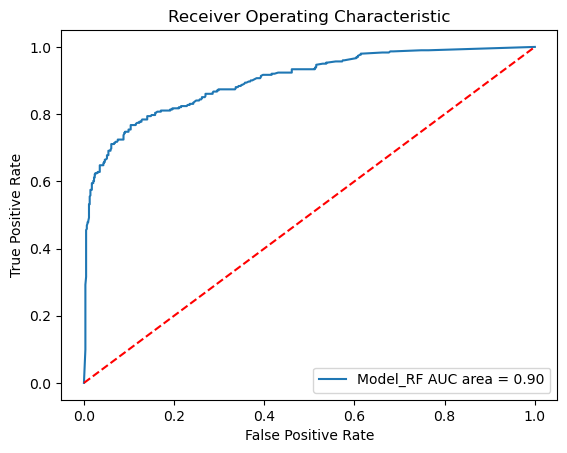

In [36]:
# Initialize the list that stores all models. First one is RF.
models = [{"label": "Model_RF", "model": model_RF}]
try:
    os.mkdir('results')
except:
    print("Directory already exists, continuing")
# Plot roc curve
plot_roc_curves_for_models(models, static_test_x, static_test_y)
result_img = '{}/results/roc_auc.png'.format(os.getcwd())
result_img

### 2.2.2 Support vector classifier (SVM)
Next up was the SVM with a radial-basis function kernel (also: squared-exponential kernel). 

In [37]:
# Specify model
model_SVM = svm.SVC(kernel="rbf", C=1, gamma=0.1, probability=True)

# Fit model on single split
performance_measures = model_training_and_validation(model_SVM, "SVM", splits)

Sensitivity: 0.73
Specificity: 0.94
AUC: 0.89


'/home/jovyan/Cheminformatics/results/roc_auc.png'

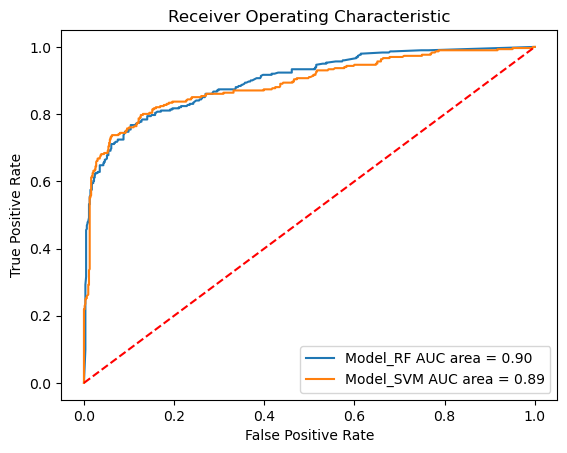

In [38]:
# Append SVM model
models.append({"label": "Model_SVM", "model": model_SVM})
# Plot roc curve
plot_roc_curves_for_models(models, static_test_x, static_test_y)
result_img = '{}/results/roc_auc.png'.format(os.getcwd())
result_img

### 2.2.3 Neural network classifier (ANN)
Lastly, a neural network model was generated. An MLPClassifier (Multi-layer Perceptron classifier) was trained with 3 layers, each with 5 neurons. As before, the crossvalidation procedure was done and the results were plotted.

In [39]:
# Specify model
model_ANN = MLPClassifier(hidden_layer_sizes=(5, 3), random_state=12)

# Fit model on single split
performance_measures = model_training_and_validation(model_ANN, "ANN", splits)

Sensitivity: 0.65
Specificity: 0.90
AUC: 0.88


'/home/jovyan/Cheminformatics/results/roc_auc.png'

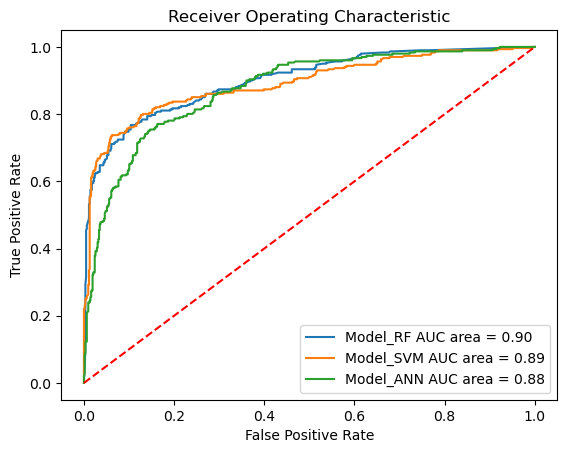

In [40]:
# Append ANN model
models.append({"label": "Model_ANN", "model": model_ANN})
# Plot roc curve
plot_roc_curves_for_models(models, static_test_x, static_test_y, True)
result_img = '{}/results/roc_auc.png'.format(os.getcwd())
result_img

All models show a AUC of ~0.9, which is very good and means they were predictive when testing the test dataset.

### 2.2.4 Cross-validation

Cross-validation experiments were performed with the three different models.
Therefore, a helper function was defined for machine learning model training and validation in a cross-validation loop.

In [41]:
def crossvalidation(ml_model, df, n_folds=5, verbose=False):
    """
    Machine learning model training and validation in a cross-validation loop.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    df: pd.DataFrame
        Data set with SMILES and their associated activity labels.
    n_folds: int, optional
        Number of folds for cross-validation.
    verbose: bool, optional
        Performance measures are printed.

    Returns
    -------
    None

    """
    t0 = time.time()
    # Shuffle the indices for the k-fold cross-validation
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=SEED)

    # Results for each of the cross-validation folds
    acc_per_fold = []
    sens_per_fold = []
    spec_per_fold = []
    auc_per_fold = []

    # Loop over the folds
    for train_index, test_index in kf.split(df):
        # clone model -- we want a fresh copy per fold!
        fold_model = clone(ml_model)
        # Training

        # Convert the fingerprint and the label to a list
        train_x = df.iloc[train_index].fp.tolist()
        train_y = df.iloc[train_index].active.tolist()

        # Fit the model
        fold_model.fit(train_x, train_y)

        # Testing

        # Convert the fingerprint and the label to a list
        test_x = df.iloc[test_index].fp.tolist()
        test_y = df.iloc[test_index].active.tolist()

        # Performance for each fold
        accuracy, sens, spec, auc = model_performance(fold_model, test_x, test_y, verbose)

        # Save results
        acc_per_fold.append(accuracy)
        sens_per_fold.append(sens)
        spec_per_fold.append(spec)
        auc_per_fold.append(auc)

    # Print statistics of results
    print(
        f"Mean accuracy: {np.mean(acc_per_fold):.2f} \t"
        f"and std : {np.std(acc_per_fold):.2f} \n"
        f"Mean sensitivity: {np.mean(sens_per_fold):.2f} \t"
        f"and std : {np.std(sens_per_fold):.2f} \n"
        f"Mean specificity: {np.mean(spec_per_fold):.2f} \t"
        f"and std : {np.std(spec_per_fold):.2f} \n"
        f"Mean AUC: {np.mean(auc_per_fold):.2f} \t"
        f"and std : {np.std(auc_per_fold):.2f} \n"
        f"Time taken : {time.time() - t0:.2f}s\n"
    )

    return acc_per_fold, sens_per_fold, spec_per_fold, auc_per_fold

Cross-validation was applied and the statistics for all three ML models were visualized. In real world conditions, cross-validation usually applies 5 or more folds, but for the sake of performance it was reduced to 3.

In [42]:
N_FOLDS = 3

_Note_: Next cell takes long to execute

In [43]:
for model in models:
    print("\n======= ")
    print(f"{model['label']}")
    crossvalidation(model["model"], compound_df, n_folds=N_FOLDS)


Model_RF
Mean accuracy: 0.85 	and std : 0.00 
Mean sensitivity: 0.74 	and std : 0.01 
Mean specificity: 0.90 	and std : 0.00 
Mean AUC: 0.90 	and std : 0.01 
Time taken : 1.40s


Model_SVM
Mean accuracy: 0.85 	and std : 0.01 
Mean sensitivity: 0.70 	and std : 0.01 
Mean specificity: 0.93 	and std : 0.01 
Mean AUC: 0.89 	and std : 0.01 
Time taken : 14.28s


Model_ANN
Mean accuracy: 0.81 	and std : 0.01 
Mean sensitivity: 0.64 	and std : 0.01 
Mean specificity: 0.90 	and std : 0.01 
Mean AUC: 0.87 	and std : 0.01 
Time taken : 5.18s



Cross-validation performance for molecules encoded was shown using MACCS keys as a default. It was tried with Morgan fingerprints as well.

In [44]:
# Reset data frame
compound_df = compound_df.drop(['fp'], axis=1)

In [45]:
# Use Morgan fingerprint with radius 3
compound_df["fp"] = compound_df["Smiles"].apply(smiles_to_fp, args=("morgan3",))
compound_df.head(3)
# NBVAL_CHECK_OUTPUT

,Molecule ChEMBL ID,pChEMBL_value,Smiles,Assay_Type,Standard Relation,Standard Value,active,fp
7,CHEMBL240624,NaN,COCCOc1ccc(N2CCN(CCn3ncc4c3nc(N)n3nc(-c5ccco5)...,B,'>',1700.0,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
8,CHEMBL382413,NaN,Cn1c(=O)c2[nH]c(-c3ccc(OCC(=O)O)cc3)cc2n(C)c1=O,B,'=',47.0,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9,CHEMBL201554,NaN,COCCCn1c(=O)n(C)c(=O)c2[nH]c(-c3ccc(OCC(=O)Nc4...,B,'=',80.0,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."


_Note_: Next cell takes long to execute

In [52]:
for model in models:
    if model["label"] == "Model_SVM":
        # SVM is super slow with long fingerprints
        # and will have a performance similar to RF
        # We can skip it in this test, but if you want
        # to run it, feel free to replace `continue` with `pass`
        pass
    print("\n=======")
    print(model["label"])
    reduced_df = compound_df[['active','fp']]
    crossvalidation(model["model"], reduced_df, n_folds=N_FOLDS)


Model_RF
Mean accuracy: 0.86 	and std : 0.01 
Mean sensitivity: 0.74 	and std : 0.02 
Mean specificity: 0.91 	and std : 0.01 
Mean AUC: 0.91 	and std : 0.01 
Time taken : 6.84s


Model_SVM
Mean accuracy: 0.80 	and std : 0.00 
Mean sensitivity: 0.46 	and std : 0.01 
Mean specificity: 0.96 	and std : 0.00 
Mean AUC: 0.85 	and std : 0.01 
Time taken : 333.84s


Model_ANN
Mean accuracy: 0.84 	and std : 0.01 
Mean sensitivity: 0.75 	and std : 0.02 
Mean specificity: 0.88 	and std : 0.01 
Mean AUC: 0.91 	and std : 0.00 
Time taken : 65.47s



So far, classification models have been running (is the compound going to be active or not, indicated by the active column we added in the dataframe). The next step is to see if a classification model can be trained. The censored data was removed (the ones with no pChEMBL value), and train another model. 

In [47]:
def crossvalidation_reg(ml_model, df, n_folds=5, verbose=False):
    """
    Machine learning model training and validation in a cross-validation loop.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    df: pd.DataFrame
        Data set with SMILES and their associated activity labels.
    n_folds: int, optional
        Number of folds for cross-validation.
    verbose: bool, optional
        Performance measures are printed.

    Returns
    -------
    None

    """
    t0 = time.time()
    # Shuffle the indices for the k-fold cross-validation
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=SEED)

    # Results for each of the cross-validation folds
    MAE_per_fold = []
    RMSE_per_fold = []

    # Loop over the folds
    for train_index, test_index in kf.split(df):
        # clone model -- we want a fresh copy per fold!
        fold_model = clone(ml_model)
        # Training

        # Convert the fingerprint and the label to a list
        train_x = df.iloc[train_index].fp.tolist()
        train_y = df.iloc[train_index].pChEMBL_value.tolist()

        # Fit the model
        fold_model.fit(train_x, train_y)

        # Testing

        # Convert the fingerprint and the label to a list
        test_x = df.iloc[test_index].fp.tolist()
        test_y = df.iloc[test_index].pChEMBL_value.tolist()
        
        test_results = fold_model.predict(test_x)
        # Prediction probability on test set
        from sklearn import metrics

        MAE_per_fold.append(metrics.mean_absolute_error(test_y, test_results))
        #print('Mean Squared Error (MSE):', metrics.mean_squared_error(test_y, test_results))
        RMSE_per_fold.append(np.sqrt(metrics.mean_squared_error(test_y, test_results)))
        #mape = np.mean(np.abs((gt - pred) / np.abs(gt)))
        #print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
        #print('Accuracy:', round(100*(1 - mape), 2))
    return(MAE_per_fold,RMSE_per_fold,fold_model)

In [48]:
fingerprint_to_model = compound_df.fp.tolist()
label_to_model = compound_df.pChEMBL_value.tolist()

# Split data randomly in train and test set
# note that we use test/train_x for the respective fingerprint splits
# and test/train_y for the respective label splits
(
    static_train_x,
    static_test_x,
    static_train_y,
    static_test_y,
) = train_test_split(fingerprint_to_model, label_to_model, test_size=0.2, random_state=12)
splits = [static_train_x, static_test_x, static_train_y, static_test_y]
# NBVAL_CHECK_OUTPUT
print("Training data size:", len(static_train_x))
print("Test data size:", len(static_test_x))

Training data size: 3710
Test data size: 928


In [49]:
# Kick out NaN in the pChEMBL values
compound_df_noNaN = compound_df.dropna()

# Append RF Regressor model
#models.append({"label": "Model_RF_reg", "model": RandomForestRegressor})
#Train model with RandomForestRegressor
regressor = RandomForestRegressor()
MAE, RMSE,trained_model = crossvalidation_reg(regressor , compound_df_noNaN, n_folds=N_FOLDS)

print(
f"MAE: {np.mean(MAE):.2f} \t"
f"and std : {np.std(MAE):.2f} \n"
f"RMSE: {np.mean(RMSE):.2f} \t"
f"and std : {np.std(RMSE):.2f} \n"
)

MAE: 0.41 	and std : 0.02 
RMSE: 0.58 	and std : 0.02 



The data is no longer categorical, so the errors between experimental data and predicted data are measured using the MAE and RMSE. Typically, an MAE below 0.6 and/or RMSE below, approximately, is considered quite decent. Therefore, the data seems to be satisfactory.

The RF model was used to run predictions on new compounds. The following compounds were designed and attempted:

![image_info](img/Differen_Ligands_pCHEMBL.jpg)

## 2.3 Affinity prediction

The output of the SMILES below is different than the original run of the model, because of the random split. The original output looked as follows:

![image info](img/SMILES_predictions.png)

This data was used to create a novel drug. **The SMILES and the images were created with ChemDraw**

In [51]:
# The first entry is the co-crystalized ligand 
# which is added for reference (so we can compare 
# to its actual pChEMBL value)
# BELOW: add your own molecules
test_smiles = [
    
    'C1CC1COC2=CC=C(C=C2)C3=C(C(=NC(=C3C#N)SCC(=O)N)N)C#N', #BAY 60-6583
    'N#CC1=C(SCC2=NC=CN2)N=C(N)C(C#N)=C1C(C=C3)=CC=C3OCC4CC4',     #Benthe
    'N#CC1=C(SCC(=O)C(N([H])[H])O[H])N=C(N([H])[H])C(CO[H])=C1C1C=C(CC)C(OCC2CC2)=CC=1',   #Tamara
    'N#CC1=C(SCC2=NC=CN2)N=C(N)C(C#N)=C1C(C=C3)=CC(CC)=C3OCC4CC4', #TamaraBentheFusion
    'N#CC1=C(SCN(C)C)N=C(N)C(C#N)=C1C(C=C2)=CC=C2OCC3CC3', #met N-2-methyl
    'N#CC1=C(SCN)N=C(N)C(C#N)=C1C(C=C2)=CC=C2OCC3CC3', #Met NH2
    'N#CC1=C(C2=CC=C(OCC3CC3)C=C2)C(C#N)=C(N=C1N)SCO', #met OH
    'N#CC1=C(C2=CC=C(O)C=C2)C(C#N)=C(N=C1N)SCO', #zonder driehoek
    'N#CC1=C(C2=CC=CC=C2)C(C#N)=C(N=C1N)SCO', #zonder driehoek en zonder O
    'N#CC1=C(C2=CC=C(O)C=C2)C(C#N)=C(N=C1N(C)C)SCO', #zonderNH2 boven
    'N#CC1=C(SCC(N)=O)N=C(O)C(C#N)=C1C(C=C2)=CC=C2OCC3CC3', #met OH boven
    'N#CC1=C(SCC(O)=O)N=C(N)C(C#N)=C1C(C=C2)=CC=C2OCC3CC3', #COOH ipc CONH2
    'N#CC1=C(SCC(N)=O)N=C(N)C=C1C(C=C2)=CC=C2OCC3CC3', # -1 =-N
    'N#CC1=C(SCC(N)=O)N=C(N)C(C#N)=C1C(C=C2)=CC=C2CCC3CC3', #zonder O in alkenechain
    'N#CC1=C(SCC2=NC=CN2)N=C(N)C(C#N)=C1C(C=C3)=CC=C3CCC4CC4', #met Benthe en zonder O in alkenechain
    'N#CC1=C(SCC2=NC=CN2)N=C(N)C(C#N)=C1C(C=C3CC)=CC=C3CCC4CC4', #met Benthe en Tamara fusion en zonder O in alkenechain
]

fps = []

for smiles in test_smiles: 
    fp = smiles_to_fp(smiles,'morgan3')
    fps.append(fp)

predictions = trained_model.predict(fps)
print("SMILES, PREDICTION")
for i, prediction in enumerate(predictions):
    print('{},{:.2f}'.format(test_smiles[i], prediction))

SMILES, PREDICTION
C1CC1COC2=CC=C(C=C2)C3=C(C(=NC(=C3C#N)SCC(=O)N)N)C#N,6.89
N#CC1=C(SCC2=NC=CN2)N=C(N)C(C#N)=C1C(C=C3)=CC=C3OCC4CC4,7.21
N#CC1=C(SCC(=O)C(N([H])[H])O[H])N=C(N([H])[H])C(CO[H])=C1C1C=C(CC)C(OCC2CC2)=CC=1,6.90
N#CC1=C(SCC2=NC=CN2)N=C(N)C(C#N)=C1C(C=C3)=CC(CC)=C3OCC4CC4,7.02
N#CC1=C(SCN(C)C)N=C(N)C(C#N)=C1C(C=C2)=CC=C2OCC3CC3,6.95
N#CC1=C(SCN)N=C(N)C(C#N)=C1C(C=C2)=CC=C2OCC3CC3,6.96
N#CC1=C(C2=CC=C(OCC3CC3)C=C2)C(C#N)=C(N=C1N)SCO,6.98
N#CC1=C(C2=CC=C(O)C=C2)C(C#N)=C(N=C1N)SCO,6.93
N#CC1=C(C2=CC=CC=C2)C(C#N)=C(N=C1N)SCO,6.90
N#CC1=C(C2=CC=C(O)C=C2)C(C#N)=C(N=C1N(C)C)SCO,6.55
N#CC1=C(SCC(N)=O)N=C(O)C(C#N)=C1C(C=C2)=CC=C2OCC3CC3,6.70
N#CC1=C(SCC(O)=O)N=C(N)C(C#N)=C1C(C=C2)=CC=C2OCC3CC3,6.79
N#CC1=C(SCC(N)=O)N=C(N)C=C1C(C=C2)=CC=C2OCC3CC3,6.62
N#CC1=C(SCC(N)=O)N=C(N)C(C#N)=C1C(C=C2)=CC=C2CCC3CC3,6.82
N#CC1=C(SCC2=NC=CN2)N=C(N)C(C#N)=C1C(C=C3)=CC=C3CCC4CC4,7.17
N#CC1=C(SCC2=NC=CN2)N=C(N)C(C#N)=C1C(C=C3CC)=CC=C3CCC4CC4,7.14


### 2.3.1 SAR Conclusion
The pCHEMBL of the original ligand was predicted to be 7.05. The first compound to be attempted was P453, which had a higher predicted pCHEMBL of 7.26.

Different side chains were tested on the R1 and R2 places. However, every attempt to replace the R1 group seemed to lower the pCHEMBL.

The R2 position was changed as well, by using a R1 group that had a low predicted affinity. By doing this, the worst predicted compounds could be created, which would give valuable information for what could be important for the binding. All attempts for the R2 position decreased the predicted affinity as well, except for the removal of the oxygen in the carbon linker.

The removal of the oxygen was tested with both the original R1 group and the R1 group of P453, which seemed to have the highest predicted affinity out of all the compounds.

This oxygen atom was already interesting, as PLIP did not assign any interactions between the protein and this particular oxygen. It even seemed to be in a hydrophobic pocket. With this removal it emphazises this hodyphobic pocket even more.


## 2.4 Discussion

* Which model performed best on our data set and why?
All of the models performed quite well. Receiver Operating Characteristic (ROC) curves show how well the models are at predicting the true positives of the test dataset. High AUCs correspond to a good predicting ability. The AUCs of the models were all comparable. The RF model showed the highest AUC.

The MACCS fingerprints were used for cross-validation. All three models showed comparable mean accuracies again, with the ANN model showing the lowest. The mean specificity was similar as well. However, the mean sensitivity of the ANN model was 0.64, compared to the 0.74 of the RF model. This is quite low.

Lastly, the models were analysed using Morgan fingerprints. The mean accuracies and mean specificities were still similar, but further apart compared to the MACCS fingerprints. However, the mean sensitivity of the SVM model was far worse than the other models, 0.46 compared to 0.74 (RF) and 0.75 (ANN).

Overall, the RF model seemed to perform the most consistently. Therefore, the right choice was made to use this model to predict the affinities of the novel ligands.

The RF model probably performed the best because the dataset is separated in active/inactive compounds. The RF format can therefore easily make decisions based on the structures it already knows to be active. ANN models generally need more data, so the model might not have been trained well enough, which is why its ability to predict true positives is low (sensitivity).

* Was MACCS the right choice?
The MACCS keys are shorter, which is why the run times of those cross-validations were only a couple seconds. However, the short keys could mean the loss of information, which is why Morgan fingerprints might be better to use. Both types gave about the same AUCs for the models though. So if MACCS keys result in a shorter running time, then is might have been the right choice.

    
### 2.4.1. Where can we go from here?

Now that the models have been trained and one model has been chosen to be the most accurate in predicting the affinity values, the model can be used to classify more unknown compounds to eventually find more partcial agonists to the hA2BR. These compounds can later be docked to evaluate their position within the protein.

However, in the next phase, only the best predicted compound was docked, which was N#CC1=C(SCC2=NC=CN2)N=C(N)C(C#N)=C1C(C=C3)=CC=C3CCC4CC4 (compound BTN1). This compound was used as a proof of concept to test whether the docking in the hA2BR would be feasible. All of the crystal structures of the protein are quite new and not a lot of docking has been attempted. So, a proof of concept is actually very valuable in this instance.


# 3. Molecular docking

In the last part of the study molecular docking is performed with the SMILES string of compound BTN1 and the protein on the Bioinformatics study.

## 3.1 Feching system and cleanup

For the next step, the protein, that was previously prepared, was extracted.

The 3D coordinate files of BAY 60-6583 (I5U) the novel ligand (BTN1) were generated.

The 3D files were generated using rdkit. The ligands were numbered automatically, so they are called ligand_00,ligand_01 etc.

### References:

[1] Korkutata, M., & Lazarus, M. (2023). Adenosine A2A receptors and sleep (Vol. 170). International Review of Neurobiology. doi: 10.1016/bs.irn.2023.04.007.

[2] Vincenzi F, Pasquini S, Contri C, Cappello M, Nigro M, Travagli A, Merighi S, Gessi S, Borea PA, Varani K. Pharmacology of Adenosine Receptors: Recent Advancements. Biomolecules. 2023 Sep 14;13(9):1387. doi: 10.3390/biom13091387.

[3] Catarzi D, Varano F, Varani K, Vincenzi F, Pasquini S, Dal Ben D, Volpini R, Colotta V. Amino-3,5-Dicyanopyridines Targeting the Adenosine Receptors Ranging from Pan Ligands to Combined A1/A2B Partial Agonists. Pharmaceuticals (Basel). 2019 Oct 22;12(4):159. doi: 10.3390/ph12040159.

[4] Adenosine receptor A2B | DrugBank Online. (z.d.). DrugBank. Geraadpleegd op 8 november 2023, van https://go.drugbank.com/bio_entities/BE0000241.

[5] Bank, R. P. D. RCSB PDB - 8HDO: Structure of A2BR bound to Synthetic Agonists BAY 60-6583. Geraadpleegd op 8 november 2023, van https://www.rcsb.org/structure/8HDO.

[6] Bank, R. P. D. RCSB PDB - 8HDP: Structure of A2BR bound to Endogenous Agonists adenosine. Geraadpleegd op 8 november 2023, van https://www.rcsb.org/structure/8HDP.

[7] National Center for Biotechnology Information (2023). PubChem Compound Summary for CID 11717831, 2-({6-Amino-3,5-dicyano-4-[4-(cyclopropylmethoxy)phenyl]pyridin-2-yl}sulfanyl)acetamide. Retrieved November 8, 2023 from https://pubchem.ncbi.nlm.nih.gov/compound/bay-60-6583.

[8] Chen Y, Zhang J, Weng Y, Xu Y, Lu W, Liu W, Liu M, Hua T, Song G. Cryo-EM structure of the human adenosine A2B receptor-Gs signaling complex. Sci Adv. 2022 Dec 23;8(51):eadd3709. doi: 10.1126/sciadv.add3709.